# Librerie

In [13]:
import pandas as pd

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

import seaborn
import numpy as np

from sklearn.linear_model import LinearRegression
from scipy.stats import multivariate_normal

In [14]:
DatasetCyclists = pd.read_csv("dataset/cyclists.csv")
DatasetRace = pd.read_csv("dataset/races_filled.csv")

## Script schema plots

In [15]:
def PlotMissingUsableData(Dataset, Name):
    
    PlotDataset = pd.DataFrame({
        "Elements": list(Dataset.keys()),
        "Total values": [Dataset.shape[0]]*len(list(Dataset.keys())),
        "Missing values": list(Dataset.isnull().sum()),
        "Usable values": list(Dataset.shape[0] - Dataset.isnull().sum())
    })

    PlotDataset.set_index('Elements', inplace=True)
    PlotDataset.plot(kind='bar', figsize=(10, 6))
    
    print(PlotDataset)

    plt.title(f'Dataset {Name} distribution')
    plt.xlabel('Features')
    plt.ylabel('Valori')
    plt.show()

In [16]:
def PlotDistributionFeatures(Dataset, Features):
    
    PlotsLambda = [lambda f, ax: ax.hist(Dataset[f], bins = 10, alpha = 0.7, color = "blue")
                   ]

    fig = plt.figure(figsize = (3*len(PlotsLambda), 2*len(Features)))   #Altezza, larghezza
    gs = gridspec.GridSpec(len(Features), len(PlotsLambda), figure=fig)
      
    i = 0

    for feature in Features:
        
        
        ax = fig.add_subplot(gs[i//len(PlotsLambda), i%len(PlotsLambda)])
        ax.set_title(feature) 
        
        for plot in PlotsLambda:    
            plot(feature, ax)
            
            i += 1

    plt.tight_layout()  # Per evitare sovrapposizioni
    plt.show()
    
    Fs = []
    i = 0
    r = 4
    

    while(i+r < len(Features)):
        Fs.append(Features[i: i+r])
        i += r
        
    if(i < len(Features)-1): Fs.append(Features[i:])
    
    Dataset = (Dataset[Features] - Dataset[Features].mean()) / Dataset[Features].std()
    
    for fs in Fs:
    
        seaborn.boxenplot(Dataset[fs], orient="h")
        plt.show()
        
        seaborn.catplot(Dataset[fs], kind="box") 
        plt.show()
    

### Restore delta values (Race dataset)

In [17]:
Races = [i[1] for i in DatasetRace.sort_values(by=["_url", "position"]).groupby('_url')]

for Race in Races:

    # Creare una colonna per identificare dove i valori sono uguali o negativi rispetto al precedente
    Race['Candidate'] = (Race['delta'].le(Race['delta'].shift().fillna(Race['delta'])) | (Race['delta'] < 0))

    # Identificare le sotto-sequenze con un identificatore unico
    Race['index_seq'] = (Race['Candidate'] == False).cumsum()
    
    Indexes = list(set(Race["index_seq"]))
    
    for i in range(len(Indexes[:-1])):

        if(Race[Race['index_seq'] == Indexes[i]].shape[0] > 4):
            
            PredictedValues = np.random.uniform(Race[Race["index_seq"] == Indexes[i]].iloc[0]["delta"],
                                  Race[Race["index_seq"] == Indexes[i+1]].iloc[0]["delta"],
                                  Race[Race["index_seq"] == Indexes[i]]["delta"].count() - 1).astype(int)
            
            PredictedValues.sort()
            
            Race.loc[Race[Race["index_seq"] == Indexes[i]].iloc[1:].index, "delta"] = PredictedValues
            
    PredictedValues = np.random.uniform(Race[Race["index_seq"] == Indexes[-1]].iloc[0]["delta"],
                                Race[Race["index_seq"] == Indexes[-1]].iloc[0]["delta"] + 2*(Race[Race["index_seq"] == Indexes[-1]]["delta"].count() - 1),
                                Race[Race["index_seq"] == Indexes[-1]]["delta"].count() - 1).astype(int)
            
    PredictedValues.sort()
            
    Race.loc[Race[Race["index_seq"] == Indexes[-1]].iloc[1:].index, "delta"] = PredictedValues
    
    del Race["Candidate"]
    del Race["index_seq"]


### Fill weight and height value (cyclist dataset)

In [19]:
TrainData = DatasetCyclists.dropna(subset=['weight', 'height'])

#Predizione dei valori sulle righe dove height c'è e weight manca (regressore lineare) e viceversa (con un altro regressore lineare)
HeightPredictor = LinearRegression()
WeightPredictor = LinearRegression()

#Allenamento dei regressori
for _ in range(1):
    HeightPredictor.fit(TrainData[['weight']], TrainData[['height']])
    WeightPredictor.fit(TrainData[['height']], TrainData[['weight']])

#Calcolo degl' indici dove andare a riempire i valori
HeightSlot = DatasetCyclists[DatasetCyclists['height'].isna() & DatasetCyclists['weight'].notna()]
WeightSlot = DatasetCyclists[DatasetCyclists['weight'].isna() & DatasetCyclists['height'].notna()]

#Calcolo dei valori mancanti
DatasetCyclists.loc[WeightSlot.index, 'weight'] = WeightPredictor.predict(WeightSlot[['height']])
DatasetCyclists.loc[HeightSlot.index, 'height'] = HeightPredictor.predict(HeightSlot[['weight']])

#Predizione dei valori sulle righe dove manca sia height che weight (distribuzione)
ColumnsCleaned = DatasetCyclists[["weight", "height"]].dropna()

#Creazione della distribuzione multivariata (2 dimensioni)
Distribution = multivariate_normal([ColumnsCleaned["weight"].mean(), ColumnsCleaned["height"].mean()],
                                   np.cov(ColumnsCleaned["weight"], ColumnsCleaned["height"]))

#Calcolo degl' indici dei valori missing
MissingIndex = DatasetCyclists[DatasetCyclists[['weight', 'height']].isna().any(axis=1)].index

#Riempimento dei valori mancanti con la distribuzione multivariata
DatasetCyclists.loc[MissingIndex, ['weight', 'height']] = Distribution.rvs(size=len(MissingIndex))


### Delete average_temperature feature (cyclist dataset)

In [21]:
#Tolgo la feautres average_temperature
del DatasetRace["average_temperature"]

### Fill birth_year (cyclist dataset)

In [23]:
DatasetCyclists.loc[DatasetCyclists["_url"] == "scott-davies", "birth_year"] = 1995
DatasetCyclists.loc[DatasetCyclists["_url"] == "vladimir-malakov", "birth_year"] = 1958
DatasetCyclists.loc[DatasetCyclists["_url"] == "antonio-zanini", "birth_year"] = 1965
DatasetCyclists.loc[DatasetCyclists["_url"] == "filippo-simonetti", "birth_year"] = 1971
DatasetCyclists.loc[DatasetCyclists["_url"] == "carlos-garcia", "birth_year"] = 1964
DatasetCyclists.loc[DatasetCyclists["_url"] == "alexandr-osipov", "birth_year"] = 1969
DatasetCyclists.loc[DatasetCyclists["_url"] == "nicolai-kosyakov", "birth_year"] = 1985
DatasetCyclists.loc[DatasetCyclists["_url"] == "nevens-guy", "birth_year"] = 1958
DatasetCyclists.loc[DatasetCyclists["_url"] == "oscar-pumar", "birth_year"] = 1970
DatasetCyclists.loc[DatasetCyclists["_url"] == "javier-luquin", "birth_year"] = 1963
DatasetCyclists.loc[DatasetCyclists["_url"] == "thierry-lauder", "birth_year"] = 1966
DatasetCyclists.loc[DatasetCyclists["_url"] == "batik-odriozola", "birth_year"] = 1970
DatasetCyclists.loc[DatasetCyclists["_url"] == "sergei-jermachenko", "birth_year"] = 1938

### Fill nationality (cyclist dataset)

In [24]:
ScottDavisIndex = DatasetCyclists[DatasetCyclists["nationality"].isnull()].index[0]
DatasetCyclists.loc[ScottDavisIndex, "nationality"] = "Great Britain"

# **Feature engineering**

# Merge the datasets

Si fa il merge delle tabelle in un unica tabella, prendendo come chiavi di riferimento la colonna "_url" del dataset cyclists e la colonna "cyclists" del dataset race.

                   Total values  Missing values  Usable values
Elements                                                      
name_cyclist             586982               0         586982
birth_year               586982               0         586982
weight                   586982               0         586982
height                   586982               0         586982
nationality              586982               0         586982
name_race                586982               0         586982
points                   586982               0         586982
uci_points               586982               0         586982
length                   586982               0         586982
climb_total              586982               0         586982
profile                  586982               0         586982
startlist_quality        586982               0         586982
date                     586982               0         586982
position                 586982               0        

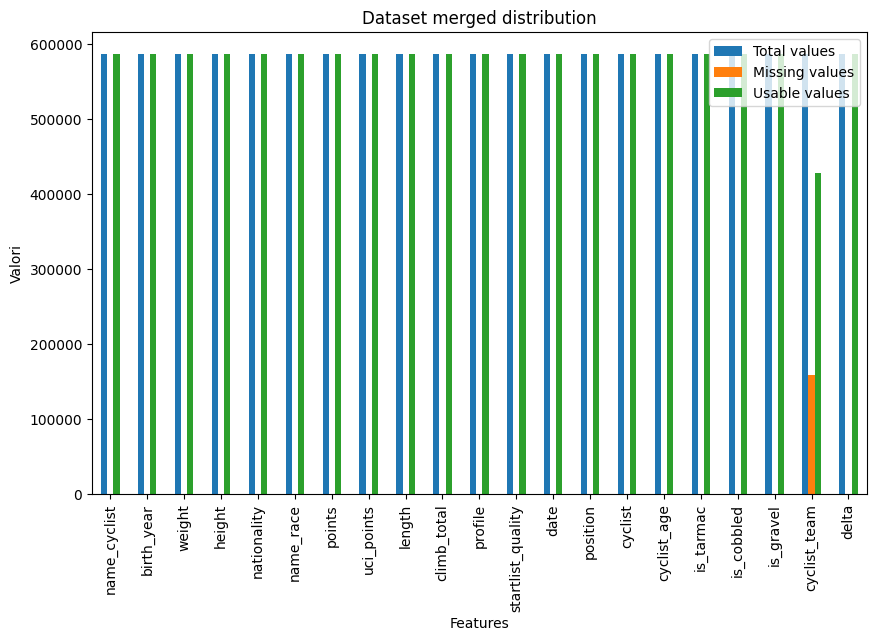

In [25]:
MergeDataset = pd.merge(DatasetCyclists, DatasetRace, left_on = "_url", right_on = "cyclist")

del MergeDataset["name_x"]
del MergeDataset["name_y"]

MergeDataset.rename(columns = {"_url_x": "name_cyclist"}, inplace = True)
MergeDataset.rename(columns = {"_url_y": "name_race"}, inplace = True)

PlotMissingUsableData(MergeDataset, "merged")




In [32]:
from sklearn.cluster import KMeans
import pandas as pd

DatasetForClustering = MergeDataset.dropna(subset=["cyclist_team"])

# Supponiamo di avere un DataFrame "data" con i dati da clusterizzare
# K-means clustering con 3 cluster
kmeans = KMeans(n_clusters=3, random_state=42)
DatasetForClustering['kmeans_cluster'] = kmeans.fit_predict(DatasetForClustering[["weight", "height"]])

print(DatasetForClustering.groupby("kmeans_cluster").nunique())  # Visualizza i cluster assegnati

C:\Users\Riccardo\AppData\Local\Temp\ipykernel_22104\338195401.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DatasetForClustering['kmeans_cluster'] = kmeans.fit_predict(DatasetForClustering[["weight", "height"]])


                name_cyclist  birth_year  weight  height  nationality   
kmeans_cluster                                                          
0                       1345          66     200     186           54  \
1                        624          67     117     103           41   
2                        851          68     149     141           54   

                name_race  points  uci_points  length  climb_total  ...   
kmeans_cluster                                                      ...   
0                    5230      56         522    1275         3015  ...  \
1                    4930      56         408    1253         2941  ...   
2                    5093      56         491    1271         2966  ...   

                startlist_quality   date  position  cyclist  cyclist_age   
kmeans_cluster                                                             
0                             697  70631       206     1345          110  \
1                             